In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import time
from datetime import timedelta
from scipy import misc
import imageio
from skimage.transform import resize
import cv2

%matplotlib inline

# Load data

In [2]:
def load_data(PATH):
    
    def load_images(filenames):
        images = np.array([imageio.imread(filename) for filename in filenames])
        return images 

    default_dir = os.getcwd()
    os.chdir(PATH)

    main_dir = os.getcwd()
    print("main_dir" + main_dir)
    sets = os.listdir()
    
    os.chdir(sets[0])

    classes = os.listdir()

    train_dir = os.getcwd()
   


    train_X = [] 
    train_Y = [] 

     
    for i in range(len(classes)):
        os.chdir(classes[i])
        filenames = os.listdir()
        
        
        train_X.append(load_images(filenames)) 
        train_Y.append(np.full((train_X[-1].shape[0], 1), i))
        os.chdir(train_dir)
        
    os.chdir(main_dir)
    os.chdir(sets[1]) 
    test_dir = os.getcwd()
    print(train_X[0].shape)
    test_X = []
    test_Y = []

    for i in range(len(classes)):
        os.chdir(classes[i])
        filenames = os.listdir()

        print(os.getcwd())
        test_X.append(load_images(filenames)) 
        test_Y.append(np.full((test_X[-1].shape[0], 1), i))
        os.chdir(test_dir)
    

    train_X = np.concatenate((train_X[0], train_X[1]), axis=0)
    train_Y = np.concatenate((train_Y), axis=0)
    

    test_X = np.concatenate((test_X[0], test_X[1]), axis=0)
    test_Y = np.concatenate((test_Y), axis=0)

    index = 43
    plt.imshow(test_X[index], cmap='gray')
    plt.title(test_Y[index])
    plt.show()

    os.chdir(default_dir)
    
    return train_X, train_Y, test_X, test_Y 


In [3]:
PATH = 'data/like_dislike/'

main_dir/home/paperspace/hand_gesture_recognition_using_raspberrypi/data/like_dislike
(501, 64, 64)
/home/paperspace/hand_gesture_recognition_using_raspberrypi/data/like_dislike/train/like
/home/paperspace/hand_gesture_recognition_using_raspberrypi/data/like_dislike/train/dislike


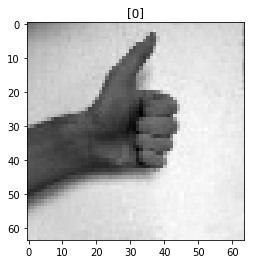

In [4]:
test_X, test_Y_class, train_X, train_Y_class = load_data(PATH)

In [5]:
img_size = 64

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_channels = 1

num_classes = 2

In [6]:
def plot_images(images, true_class, pred_class=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_size, img_size), cmap='gray')
        
        if pred_class is None:
            xlabel = f"True: {true_class[i]}"
        else:
            xlabel = f"True: {true_class[i]}, Pred: {pred_class[i]}"
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()    

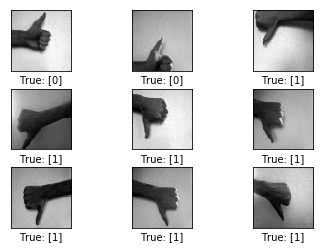

In [7]:
index = 3500

images = train_X[index:index+10]

true_class = train_Y_class[index:index+10]

plot_images(images=images, true_class=true_class)

## Data preprocessing

In [8]:
def resize_img(img, img_size):
    y = math.floor((img_size/img.shape[0]) * img.shape[1])
    return resized

def preprocess_images(X):
    X = (X / 255 * 0.99) + 0.01
    return np.float32(X).reshape(-1, img_size, img_size, num_channels)

def one_hot(nums):
    output = np.eye(num_classes)[nums]
    return np.squeeze(output)



In [9]:
train_X = preprocess_images(train_X)
test_X = preprocess_images(test_X)

train_Y = one_hot(train_Y_class)
test_Y = one_hot(test_Y_class)


print(f"Number of train examples: {train_X.shape[0]}")
print(f"Number of test examples: {test_X.shape[0]}")
print(f"Train images shape: {train_X.shape}")
print(f"Test images shape: {test_X.shape}")
print(f"Train Labels shape: {train_Y.shape}")
print(f"Test Labels shape: {test_Y.shape}")

Number of train examples: 6005
Number of test examples: 1001
Train images shape: (6005, 64, 64, 1)
Test images shape: (1001, 64, 64, 1)
Train Labels shape: (6005, 2)
Test Labels shape: (1001, 2)


# Model

## Conv net hyper parameters

In [10]:
filter_size1 = 3
num_filters1 = 8

filter_size2 = 3
num_filters2 = 16

fc_layer = 256

lr=0.0005

## Conv layer

In [11]:
def create_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    
    filter_shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    print(filter_shape)
    
    weights = tf.Variable(tf.truncated_normal(shape=filter_shape))
    
    biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
    
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1, 1, 1, 1],
                         padding='SAME')
    
    layer += biases
    
    if use_pooling:
        
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        
    layer = tf.nn.relu(layer)
    
    return layer, weights

## FC layer

In [12]:
def create_fully_connected(input,
                          num_inputs,
                          num_outputs,
                          use_relu=True):
    
    weights = tf.Variable(tf.truncated_normal(shape=[num_inputs, num_outputs]))
    
    biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

## Flatten conv layer

In [13]:
def flatten_layer(layer):
    
    layer_shape = layer.get_shape()
    
    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

## Placeholders

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')

## Conv 1

In [15]:
layer_conv1, weights_conv1 = create_conv_layer(input=x,
                                              num_input_channels=num_channels,
                                              filter_size=filter_size1,
                                              num_filters=num_filters1,
                                              use_pooling=True)

[3, 3, 1, 8]


In [16]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 8) dtype=float32>

## Conv 2

In [17]:
layer_conv2, weights_conv2 = create_conv_layer(input=layer_conv1,
                                              num_input_channels=num_filters1,
                                              filter_size=filter_size2,
                                              num_filters=num_filters2,
                                              use_pooling=True)

[3, 3, 8, 16]


In [18]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 16) dtype=float32>

## FC1

In [19]:
layer_flat, num_features = flatten_layer(layer_conv2)
print(f"Num features: {num_features}")

Num features: 4096


In [20]:
fc_layer1 = create_fully_connected(input=layer_flat,
                                  num_inputs=num_features,
                                  num_outputs=fc_layer,
                                  use_relu=True)

In [21]:
fc_layer1

<tf.Tensor 'Relu_2:0' shape=(?, 256) dtype=float32>

In [22]:
dropout = tf.layers.dropout(inputs=fc_layer1, rate=0.4, training=False)

In [23]:
fc_layer2 = create_fully_connected(input=dropout,
                                  num_inputs=fc_layer,
                                  num_outputs=num_classes,
                                  use_relu=False)

In [24]:
fc_layer2

<tf.Tensor 'add_3:0' shape=(?, 2) dtype=float32>

## Softmax

In [25]:
y_pred = tf.nn.softmax(fc_layer2)
y_pred_class = tf.argmax(y_pred, axis=1)

In [26]:
y_pred_class

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

In [27]:
train_Y_class.reshape(-1).shape

(6005,)

## Cost

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc_layer2, labels=y)

In [29]:
cost = tf.reduce_mean(cross_entropy)

## Optimizer

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

## Accuracy

In [31]:
correct_predictions = tf.equal(y_pred_class, train_Y_class.reshape(-1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

## Saver

In [32]:
saver = tf.train.Saver()

In [33]:
save_dir = 'checkpoints/onetwo256dropout/'

## Running Tensorflow session

In [34]:
session = tf.Session()

In [35]:
session.run(tf.global_variables_initializer())

In [36]:
# saver.restore(sess=session, save_path=save_dir)

## Minibatch helper function

In [37]:
batch_size = 128

In [38]:
def split_into_batches(X, Y):
    full_sized = math.floor(X.shape[0] / batch_size)
    print(f"Full sized: {full_sized}")
    batches_X = []
    batches_Y = []
    
    for i in range(full_sized):
        batches_X.append(X[i*batch_size:(i+1) * batch_size])
        batches_Y.append(Y[i*batch_size:(i+1) * batch_size])
        
        
    last_elems = full_sized * batch_size - X.shape[0]
    if last_elems != 0:
        print(f"kasel")
        batches_X.append(X[last_elems:])
        batches_Y.append(Y[last_elems:])
        
    return batches_X, batches_Y
    
    

In [39]:
%%time
print("kasel")

kasel
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 114 µs


In [40]:
total_epochs = 0
def optimize(num_epochs):
     
    global total_epochs
    start_time = time.time()
    
    for i in range(total_epochs, total_epochs + num_epochs):
        
        for x_batch, y_batch in zip(X_batches, Y_batches):
            
            feed_dict_train = {x: x_batch,
                              y: y_batch}
            
#             print(feed_dict_train[x].shape)
#             print(feed_dict_train[y].shape)
            
            session.run(optimizer, feed_dict=feed_dict_train)
#             print(":)")
        
        feed_dict_train_acc = {x: train_X, y: train_Y}
        acc = session.run(accuracy, feed_dict=feed_dict_train_acc)
    
        print(f"Epoch {i}: Train_acc: {str(acc*100)[:5]}%")
        
    total_epochs += num_epochs
    
    end_time = time.time()
    
    time_dif = end_time - start_time
    
    print(f"Time usage: {timedelta(seconds=int(round(time_dif)))}")

In [41]:
def print_accuracy(X, Y):
    feed_dict_test = {x: X,
                     y: Y}
   
    pred_class = session.run(y_pred_class, feed_dict=feed_dict_test)
    
    true_class = np.argmax(Y, axis=1)
    pred_class = np.array(pred_class)
    correct = (pred_class == true_class)
    
    correct_sum = correct.sum()
    
    acc = float(correct_sum) / len(correct)
    
    return acc
    print(f"Test accuracy: {str(acc * 100)[:5]}%")

# Training

In [42]:
X_batches, Y_batches = split_into_batches(train_X, train_Y)

Full sized: 46
kasel


In [43]:
print(test_X.shape)

(1001, 64, 64, 1)


In [44]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 51.44%
Train accuracy: 45.39%


In [45]:
optimize(num_epochs=1)

Epoch 0: Train_acc: 41.68%
Time usage: 0:00:01


In [46]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 49.95%
Train accuracy: 41.68%


In [47]:
optimize(num_epochs=5)

Epoch 1: Train_acc: 43.18%
Epoch 2: Train_acc: 49.79%
Epoch 3: Train_acc: 56.55%
Epoch 4: Train_acc: 60.96%
Epoch 5: Train_acc: 66.66%
Time usage: 0:00:02


In [48]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 71.32%
Train accuracy: 66.66%


In [49]:
optimize(num_epochs=10)

Epoch 6: Train_acc: 68.90%
Epoch 7: Train_acc: 70.97%
Epoch 8: Train_acc: 73.77%
Epoch 9: Train_acc: 74.32%
Epoch 10: Train_acc: 72.35%
Epoch 11: Train_acc: 73.37%
Epoch 12: Train_acc: 71.89%
Epoch 13: Train_acc: 75.10%
Epoch 14: Train_acc: 75.55%
Epoch 15: Train_acc: 79.35%
Time usage: 0:00:05


In [50]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 80.51%
Train accuracy: 79.35%


In [51]:
optimize(num_epochs=10)

Epoch 16: Train_acc: 79.76%
Epoch 17: Train_acc: 83.56%
Epoch 18: Train_acc: 87.01%
Epoch 19: Train_acc: 89.65%
Epoch 20: Train_acc: 91.84%
Epoch 21: Train_acc: 94.08%
Epoch 22: Train_acc: 94.72%
Epoch 23: Train_acc: 95.35%
Epoch 24: Train_acc: 95.72%
Epoch 25: Train_acc: 96.46%
Time usage: 0:00:05


In [52]:
optimize(num_epochs=20)

Epoch 26: Train_acc: 96.66%
Epoch 27: Train_acc: 96.28%
Epoch 28: Train_acc: 96.75%
Epoch 29: Train_acc: 97.11%
Epoch 30: Train_acc: 96.96%
Epoch 31: Train_acc: 97.70%
Epoch 32: Train_acc: 97.65%
Epoch 33: Train_acc: 97.98%
Epoch 34: Train_acc: 98.45%
Epoch 35: Train_acc: 98.48%
Epoch 36: Train_acc: 98.85%
Epoch 37: Train_acc: 99.01%
Epoch 38: Train_acc: 99.03%
Epoch 39: Train_acc: 99.20%
Epoch 40: Train_acc: 99.28%
Epoch 41: Train_acc: 99.36%
Epoch 42: Train_acc: 99.48%
Epoch 43: Train_acc: 99.50%
Epoch 44: Train_acc: 99.56%
Epoch 45: Train_acc: 99.60%
Time usage: 0:00:09


In [53]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 98.90%
Train accuracy: 99.60%


In [54]:
optimize(num_epochs=10)

Epoch 46: Train_acc: 99.63%
Epoch 47: Train_acc: 99.71%
Epoch 48: Train_acc: 99.76%
Epoch 49: Train_acc: 99.80%
Epoch 50: Train_acc: 99.80%
Epoch 51: Train_acc: 99.78%
Epoch 52: Train_acc: 99.85%
Epoch 53: Train_acc: 99.78%
Epoch 54: Train_acc: 99.80%
Epoch 55: Train_acc: 99.86%
Time usage: 0:00:05


In [55]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 99.20%
Train accuracy: 99.86%


In [56]:
optimize(num_epochs=50)

Epoch 56: Train_acc: 99.90%
Epoch 57: Train_acc: 99.90%
Epoch 58: Train_acc: 99.83%
Epoch 59: Train_acc: 99.93%
Epoch 60: Train_acc: 99.95%
Epoch 61: Train_acc: 99.95%
Epoch 62: Train_acc: 99.90%
Epoch 63: Train_acc: 99.88%
Epoch 64: Train_acc: 99.95%
Epoch 65: Train_acc: 99.95%
Epoch 66: Train_acc: 99.95%
Epoch 67: Train_acc: 99.95%
Epoch 68: Train_acc: 99.96%
Epoch 69: Train_acc: 99.90%
Epoch 70: Train_acc: 99.90%
Epoch 71: Train_acc: 99.96%
Epoch 72: Train_acc: 99.96%
Epoch 73: Train_acc: 99.96%
Epoch 74: Train_acc: 99.95%
Epoch 75: Train_acc: 99.91%
Epoch 76: Train_acc: 99.96%
Epoch 77: Train_acc: 99.95%
Epoch 78: Train_acc: 100.0%
Epoch 79: Train_acc: 99.96%
Epoch 80: Train_acc: 99.96%
Epoch 81: Train_acc: 99.98%
Epoch 82: Train_acc: 100.0%
Epoch 83: Train_acc: 100.0%
Epoch 84: Train_acc: 100.0%
Epoch 85: Train_acc: 100.0%
Epoch 86: Train_acc: 100.0%
Epoch 87: Train_acc: 100.0%
Epoch 88: Train_acc: 100.0%
Epoch 89: Train_acc: 100.0%
Epoch 90: Train_acc: 100.0%
Epoch 91: Train_acc:

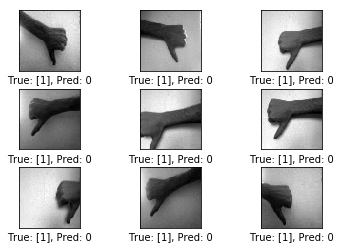

In [57]:
index = 900


images = test_X[index:index+10]

true_class = test_Y_class[index:index+10]

feed_dict_test = {x: test_X, y: test_Y}

preds = session.run(y_pred_class, feed_dict=feed_dict_test)
# print(preds.shape)


plot_images(images=images, true_class=true_class, pred_class=preds)

In [58]:
saver.restore(sess=session, save_path=save_dir)

INFO:tensorflow:Restoring parameters from checkpoints/onetwo256dropout/
